In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import gudhi as gd
from sklearn.neighbors import KernelDensity, KDTree
import random
import multiprocessing
from scipy.cluster import hierarchy
import matplotlib.gridspec as gds
import matplotlib

## Preprocessing:

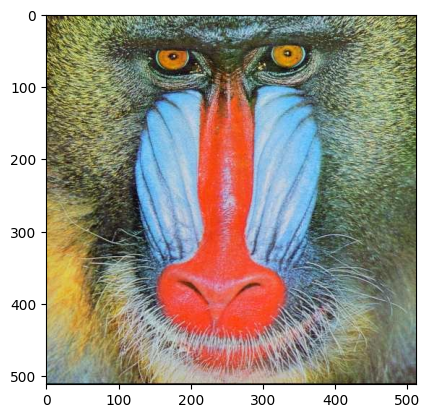

In [2]:
img_rgb = plt.imread('data/baboon.png', 'PNG')
plt.imshow(img_rgb)

In [3]:
img_rgb.shape

(512, 512, 3)

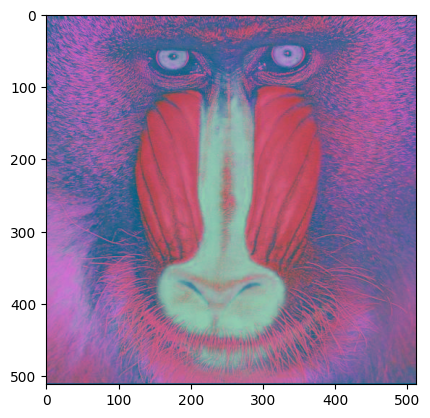

In [4]:
img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
plt.imshow(img_luv)

In [5]:
img_luv.shape

(512, 512, 3)

In [6]:
gap = 2
img_luv = np.asarray([[list(img_luv[i, j, :]) for j in range(0,img_luv.shape[1], gap)]
    for i in np.arange(0,img_luv.shape[0], gap)])

In [7]:
img_luv.shape

(256, 256, 3)

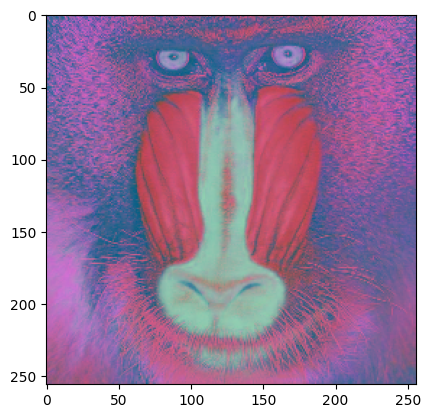

In [8]:
plt.imshow(img_luv)

In [9]:
l, u, v = [], [], []
for i in range(img_luv.shape[0]):
    for j in range(img_luv.shape[1]):
        l.append(img_luv[i, j, 0])
        u.append(img_luv[i, j, 1])
        v.append(img_luv[i, j, 2])

In [10]:
x = np.vstack((l, u, v)).T
x.shape

(65536, 3)

In [11]:
print(x)

[[140 103 170]
 [ 87 103 163]
 [168 103 166]
 ...
 [ 89 100 141]
 [ 84 100 141]
 [ 81 100 141]]


# Parallelizing density approximation:

In [12]:
def parallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

In [13]:
kde = KernelDensity(bandwidth=2.0, atol=0.0005, rtol=0.01).fit(x) 
log_prob = parallel_score_samples(kde, x)

In [14]:
prob = np.exp(log_prob)

# Calculating Vietoris-Rips complex sigma:

In [15]:
sparse = 3
sparse_matrix = np.asarray([[(j%sparse==0)&(i%sparse==0) for i in range(img_luv.shape[1])] for j in range(img_luv.shape[0])])
sparse_array = sparse_matrix.flatten()

In [16]:
x_train = x[sparse_array]
x_train = np.asarray([list(x_train[random.randrange(x_train.shape[0])]) for i in np.arange(20000)])
x_train.shape

(20000, 3)

In [17]:
linked = hierarchy.linkage(x_train, 'single')

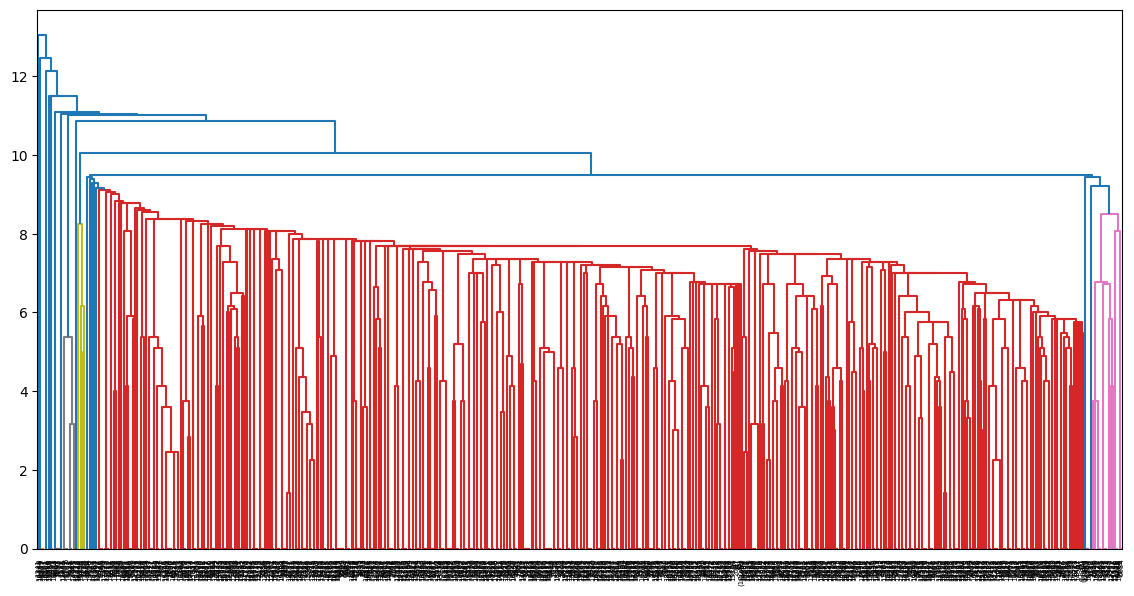

In [18]:
plt.figure(figsize=(14, 7))
hierarchy.dendrogram(linked, p=100, truncate_mode='level')
plt.show()

In [19]:
kdt = KDTree(x, metric='euclidean')

In [20]:
sigmas = np.linspace(0, 20, 10)
avg_neighbor_count = [np.mean([kdt.query_radius([x_train[i]], sigmas[j], return_distance=False)[0].shape[0] for i in range(x_train.shape[0])]) 
           for j in range(len(sigmas))]

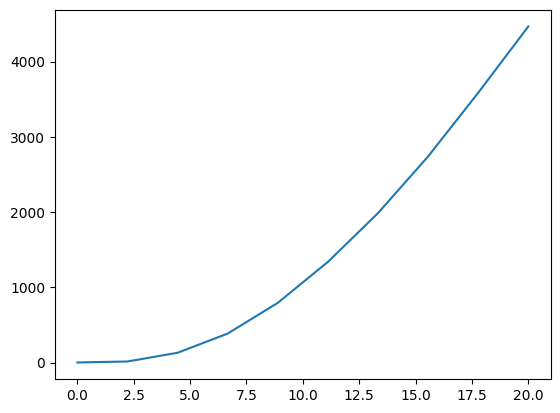

In [21]:
plt.plot(sigmas, avg_neighbor_count)

In [22]:
sigma = 4

# Reducing the number of used points:

In [23]:
group_matrix = np.asarray([[i+j*img_luv.shape[0] for i in np.arange(0, img_luv.shape[1], sparse) for _ in range(sparse)] 
                         for j in np.arange(0, img_luv.shape[0], sparse) for _ in range(sparse)]).flatten()

In [24]:
marked = np.asarray([-1 if sparse_array[i] else group_matrix[i] for i in range(x.shape[0])])
m = 20
for ind in range(x.shape[0]):
    if (marked[ind] == -1):
        nei_drop = kdt.query_radius([x[ind]], sigma/m, return_distance=False)[0]
        nei_drop = np.delete(nei_drop, np.where(nei_drop == ind))
        nei_drop = [elem for elem in nei_drop if marked[elem]==-1]
        marked[nei_drop] = ind

In [25]:
np.sum(marked==-1)

7130

# Implementing disjoint-set data structure:

In [26]:
class UnionFind:
    def __init__(self):
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.parent = {}
    
    def insert(self, object):
        obj_num = len(self.objects_to_num)
        self.objects_to_num[object] = obj_num
        self.num_to_objects[obj_num] = object
        self.parent[obj_num] = obj_num
    
    def find(self, object): 
        if not object in self.objects_to_num:
            self.insert(object)
            return object
        
        stk = [self.objects_to_num[object]]
        par = self.parent[stk[-1]]

        while par != stk[-1]:
            stk.append(par)
            par = self.parent[par]

        for i in stk: self.parent[i] = par
            
        return self.num_to_objects[par]
        
    def union(self, object1, object2): 
        first = self.find(object1)
        second = self.find(object2)
        if first != second:
            first_num = self.objects_to_num[first]
            second_num = self.objects_to_num[second]
            self.parent[second_num] = first_num

# Main clustering function:

In [27]:
def cluster(prob, sigma, tau, x):
    sorted_indices = np.argsort(prob)
    U = UnionFind()
    n = len(prob)
    births = {}
    deaths = {}
    
    for i in reversed(range(n)):
        id = sorted_indices[i]
        if (marked[id]==-1):
            neighbors = kdt.query_radius([x[id]], sigma, return_distance=False)[0]
            S = [elem for elem in neighbors if (elem in sorted_indices[(i+1):] and (marked[elem]==-1))]
            if not S:
                U.insert(id)
                births[id] = -prob[id]
            else:
                parent = S[np.asarray([prob[j] for j in S]).argmax()]
                U.union(parent, id)
                # spajanje
                ei = U.find(id)
                roots = [U.find(ele) for ele in S]
                for ej in roots:
                    if ei != ej and prob[U.find(ej)] - prob[id] < tau:
                        U.union(ei, ej)
                        deaths[ej] = -prob[id]
                e_ = -1
                for ej in roots:
                    if e_ == -1 or prob[U.find(ej)] > prob[U.find(e_)]:
                        e_ = ej
                if ei != e_ and prob[U.find(ei)] - prob[id] < tau:
                    U.union(e_, ei)
                    deaths[ei] = -prob[id]

    for i in births.keys():
        if i not in deaths.keys():
            deaths[i] = np.inf
        
    return U, births, deaths

In [28]:
U, births, deaths = cluster(prob, sigma, np.inf, x)

# Plotting persistence diagram:

In [29]:
lifecycle = [(births[idx], deaths[idx]) for idx in births.keys()]

In [30]:
res = [(0, elem) for elem in lifecycle]

In [31]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
_ = sorted([elem for elem in persistence if ~np.isinf(elem)], reverse=True)

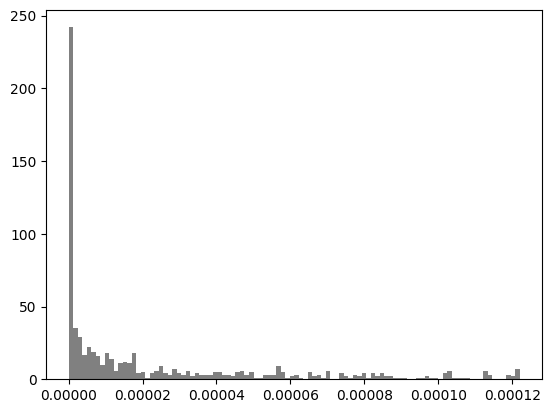

In [32]:
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100, color = 'gray')
plt.show()

/home/jormundur/.local/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Figure size 1800x400 with 0 Axes>

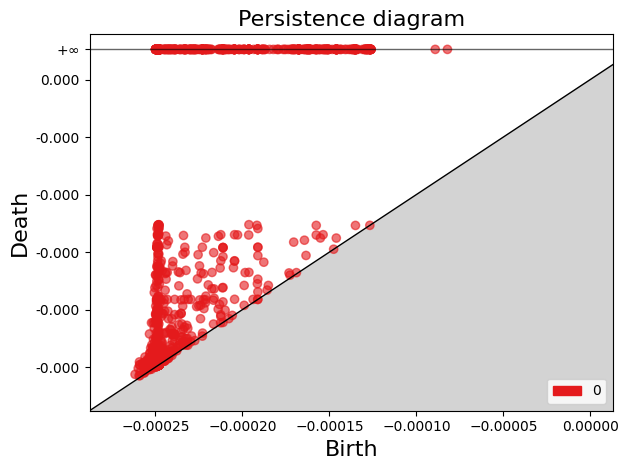

In [33]:
import matplotlib

plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_diagram(res)
plt.tight_layout()
plt.show()

<Figure size 1800x400 with 0 Axes>

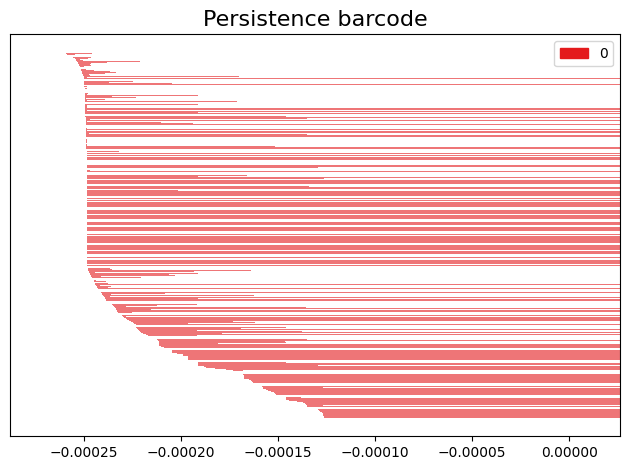

In [34]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

In [35]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

Function to graph x = y:

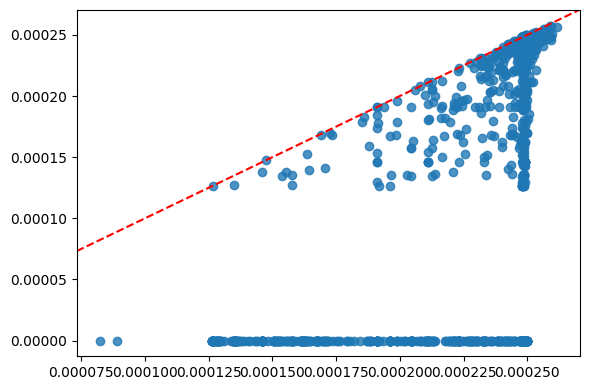

In [36]:
lifecycle_mod = [(-elem[0], 0) if elem[1]==np.inf else (-elem[0], -elem[1]) for elem in lifecycle]
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter([elem[0] for elem in lifecycle_mod], [elem[1] for elem in lifecycle_mod], alpha=0.8)
add_identity(ax, color='red', ls='--')
plt.tight_layout()
plt.show()

In [37]:
U, births, deaths = cluster(prob, sigma=sigma, tau=0.00002, x=x)

In [38]:
len(np.unique(list(U.parent.values())))

1094

In [39]:
np.unique(list(U.parent.values()))

array([  30,   52,   83, ..., 7110, 7128, 7129])

# Centroid calculation:

In [40]:
cen, sts = [], []
ind = np.asarray(list(U.num_to_objects.values()))
rts = np.asarray(list(U.parent.values()))

In [41]:
for ele in np.unique(rts):
    cen.append(U.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [42]:
cen = np.asarray(cen)

In [43]:
threshold = 25
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

Broj klastera vecih od  25  je  18


Function to generate random colorings for future clusters:

In [44]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+123)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0,0,0])
    return colors
colors = cluster_color(cen)

# Grouping points belonging to same clusters:

In [45]:
idxs = []
for idx, grp in enumerate(sts):
    idxs = idxs + list(np.repeat(idx, len(sts[idx])))

In [46]:
grps = []
for idx, grp in enumerate(sts):
    grps = grps + list(grp)

In [116]:
cluster_dict = {k: v for k,v in zip(grps, idxs)}

In [117]:
idxs_all = idxs + [cluster_dict[elem] for idx,elem in enumerate(marked) if elem!=-1]
len(idxs_all)

KeyError: 978

In [99]:
grps_all = grps + [idx for idx,elem in enumerate(marked) if elem!=-1]
len(grps_all)

65536

In [89]:
cluster_sort = sorted(zip(grps_all, idxs_all))
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]
len(img_clustered)

IndexError: list index out of range

In [ ]:
img_clustered_all = np.reshape(np.asarray(img_clustered), img_luv.shape)
img_clustered_all.shape

In [87]:
len(colors)

1094